In [1]:
import os
import sys
import glob
import numpy as np
import random
import typing as typ
from copy import deepcopy
import datetime

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchsummary

In [3]:
from livelossplot import PlotLosses

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
# sys.path.insert(0, "../mesh_to_sdf")
sys.path.insert(0, "../")

In [25]:
from deep_sdf.networks.deep_sdf_decoder import Decoder
from deep_sdf.utils.data import SDFSamples, list_files
from deep_sdf.utils.lr_schedule import StepLearningRateSchedule
from deep_sdf.utils.mesh import create_mesh
from deep_sdf.utils.metrics import compute_trimesh_chamfer

In [7]:
# import mesh_to_sdf as msdf
import trimesh
import pyrender
import skimage.measure
import k3d
import matplotlib
import plyfile
import skimage.measure
import time

### Working directories

In [21]:
ROOT = "../"
EXPERIMENTS_DIR = os.path.join(ROOT, "experiments", "baseline")
DATA_MESH_DIR = os.path.join(ROOT, "data", "planes_sample")
DATA_SPLITS_DIR = os.path.join(EXPERIMENTS_DIR, "splits")
RECONSTRUCTION_DIR = os.path.join(EXPERIMENTS_DIR, "reconstruction")
CLASS_NAME = 'plane' 
SAMPLED_VISIBLE_MESH_SURFACE_DIR = os.path.join(EXPERIMENTS_DIR, "data", CLASS_NAME, "visible_surface")
TEST_DIR = os.path.join(EXPERIMENTS_DIR, "data", CLASS_NAME, "test")
TRAIN_DIR = os.path.join(EXPERIMENTS_DIR, "data", CLASS_NAME, "train")

os.makedirs(DATA_SPLITS_DIR, exist_ok=True)

print(ROOT)
print(EXPERIMENTS_DIR)
print(DATA_MESH_DIR)
print(DATA_SPLITS_DIR)
print(RECONSTRUCTION_DIR)
print(SAMPLED_VISIBLE_MESH_SURFACE_DIR)
print(TEST_DIR)
print(TRAIN_DIR)
print(CLASS_NAME)

../
../experiments/baseline
../data/planes_sample
../experiments/baseline/splits
../experiments/baseline/reconstruction
../experiments/baseline/data/plane/visible_surface
../experiments/baseline/data/plane/test
../experiments/baseline/data/plane/train
plane


In [9]:
def get_color(value: float, palette: str = "RdBu"):
    cmap = matplotlib.cm.get_cmap("RdBu")
    return int(matplotlib.colors.rgb2hex(cmap(value * 2.0)[:3]).replace("#", ''), 16)

def plot_sdf_3d(data: np.ndarray, size: float = 1e-2):
    """
    :param data: Nx4 [x, y, z, sdf]
    """
    plot = k3d.plot()
    colors = np.array(list(map(get_color, data[:, -1])), dtype=np.uint32)
    plot += k3d.points(data[:, :-1], colors=colors, point_size=size)
    plot.display()

In [10]:
def is_cuda(model: torch.nn.Module) -> bool:
    """
    https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
    """
    return next(model.parameters()).is_cuda

### Model Config
- **TODO**: make from yaml file

In [11]:
NUM_LAYERS = 8
NUM_NEURONS = 512

# initialize model
# https://github.com/facebookresearch/DeepSDF/blob/master/examples/chairs/specs.json
CONFIG = {
    "two_d": False,
    "latent_size": 0, 
    "dims": [512] * 8,                       # [NUM_NEURONS] * NUM_LAYERS
    "dropout": [0, 1, 2, 3, 4, 5, 6, 7],     # list(range(0, NUM_LAYERS))
    "dropout_prob": 0.2,
    "norm_layers": [0, 1, 2, 3, 4, 5, 6, 7], # list(range(0, NUM_LAYERS))
    "latent_in": [],
    "xyz_in_all": False,
    "use_tanh": False,
    "latent_dropout": False,
    "weight_norm": True
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
def save_model(filename: str, model: torch.nn.Module):
    torch.save(model.state_dict(),  filename)
    print(f"Saved to {filename}")

def save_checkpoints(directory:str, epoch: int, model: torch.nn.Module):
    save_model(os.path.join(directory, str(epoch) + ".pth"), model)
    
def load_model(config: dict, filename: typ.Optional[str] = None, device: str = "cpu") -> torch.nn.Module:
    model = Decoder(**config)
    model = model.to(device)
    if isinstance(filename, str):
        if os.path.isfile(filename):
            model.load_state_dict(torch.load(filename))
        else:
            print(f"File not exists: {filename}")
    return model

### DataLoaders

In [21]:
NUM_SAMPLES_PER_SCENE = 16384 // 2  # 
NUM_SCENES_PER_BATCH = 2       # 64
NUM_DATA_LOADER_WORKERS = 1   # 16

In [58]:
npyfiles = list_files(os.path.join(EXPERIMENTS_DIR, "data", CLASS_NAME, "train"), ".npz")
train_dataset = SDFSamples(npyfiles, NUM_SAMPLES_PER_SCENE, load_ram=True)
print(f"Train. Found {len(train_dataset)} scenes")

npyfiles = list_files(os.path.join(EXPERIMENTS_DIR, "data", CLASS_NAME, "test"), ".npz")
test_dataset = SDFSamples(npyfiles, NUM_SAMPLES_PER_SCENE, load_ram=True)
print(f"Test. Found {len(test_dataset)} scenes")

Train. Found 8 scenes
Test. Found 3 scenes


In [59]:
# DataLoader:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=NUM_SCENES_PER_BATCH,
    shuffle=True,
    num_workers=NUM_DATA_LOADER_WORKERS,
    drop_last=True,
)

test_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=NUM_SCENES_PER_BATCH,
    shuffle=False,
    num_workers=NUM_DATA_LOADER_WORKERS,
)

dataloaders = {
    'train': train_loader,
    'validation': test_loader,
}

In [17]:
MODEL_WEIGHTS = os.path.join(EXPERIMENTS_DIR, "checkpoints/2020-07-01_20:58:02/100.pth")  # initial model
MODEL_WEIGHTS = os.path.join(EXPERIMENTS_DIR, "checkpoints/2020-07-01_22:58:56/900.pth")  # Best model
# MODEL_WEIGHTS = None

In [18]:
model = load_model(CONFIG, MODEL_WEIGHTS, device)

### Training

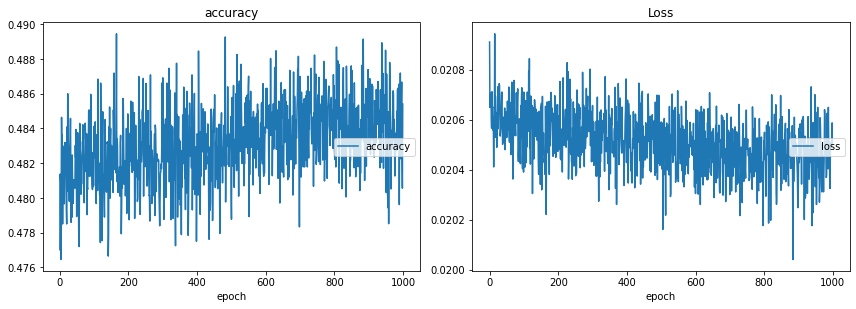

accuracy
	accuracy         	 (min:    0.476, max:    0.489, cur:    0.485)
Loss
	loss             	 (min:    0.020, max:    0.021, cur:    0.020)


In [64]:
# example:
# https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
liveloss = PlotLosses()

SDF_TOLERANCE = 1e-2

model = model.to(device)

epochs = 1000
save_each = 100

experiments_dir = os.path.join(EXPERIMENTS_DIR, "checkpoints",
                               datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
os.makedirs(experiments_dir, exist_ok=True)

# source: 
# https://github.com/facebookresearch/DeepSDF/blob/master/train_deep_sdf.py#L378
# api: https://pytorch.org/docs/master/generated/torch.nn.L1Loss.html
loss_l1 = torch.nn.L1Loss(reduction="sum")

# learning parameters:
# https://github.com/facebookresearch/DeepSDF/blob/master/examples/chairs/specs.json#L23
learning_rate = 0.0005 * 0.5**3 # initial
learning_rate_schedule = StepLearningRateSchedule(initial=learning_rate, interval=500, factor=0.5)

# api: https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adam([
    {
        "params": model.parameters(),
        "lr": learning_rate_schedule.get_learning_rate(0),
    }
])

logs = {}
for epoch in range(epochs):
    logs = {}
    
    # update learning rate
    # With constant learning rate plato observed
    optimizer.param_groups[0]["lr"] = learning_rate_schedule.get_learning_rate(epoch)
    
    for phase in ['train']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total_items = 0
        for sdf_data, indices in dataloaders[phase]:
            # sdf_data: torch.Tensor [2, NUM_SAMPLES_PER_SCENE, 4]
            # indices: torch.Tensor  [2, ] ([0, 1])
    
            # Process the input data (remove first dimension)
            sdf_data = sdf_data.reshape(-1, 4)  # [2 * NUM_SAMPLES_PER_SCENE, 4] 
            num_sdf_samples = sdf_data.shape[0]
    
            xyz = sdf_data[:, 0:3]  # [2 * NUM_SAMPLES_PER_SCENE, 3] 
    
            num_sdf_samples = sdf_data.shape[0]

            sdf_data.requires_grad = False
            sdf_gt = sdf_data[:, 3].unsqueeze(1) # [2 * NUM_SAMPLES_PER_SCENE, 1] 
            
            inputs = xyz.to(device)
            labels = sdf_gt.to(device)
            
            outputs = model(inputs)     # [batch_size, 1]
            
            loss = F.l1_loss(outputs, labels)
            
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            running_loss += loss.detach() * inputs.size(0)
            
            abs_error = torch.abs(outputs - labels)
            # assume correct SDF values wrt tolerance value
            running_corrects += torch.sum(abs_error < SDF_TOLERANCE)
            total_items += labels.shape[0]
        epoch_loss = running_loss / total_items
        epoch_acc = running_corrects.float() / total_items
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'loss'] = epoch_loss.item()
        logs[prefix + 'accuracy'] = epoch_acc.item()

    if epoch % save_each == 0:
        save_checkpoints(experiments_dir, epoch, model) 
        
    liveloss.update(logs)
    liveloss.send() 

In [27]:
def reconstruct(processed_mesh_filename: str, reconstructed_filename: str, model: torch.nn.Module):
    processed_mesh = np.load(processed_mesh_filename)
    processed_mesh = np.vstack((processed_mesh['neg'], processed_mesh['pos']))
    
    create_mesh(model, None, reconstructed_filename, max_batch=32**3)

In [29]:
def reconstruct_all(processed_mesh_dir: str, reconstruction_dir: str):

    test_processed_mesh = list_files(processed_mesh_dir, ".npz")
    for fl in test_processed_mesh:
        filename = os.path.basename(fl).replace(".npz", "")
        out_file = os.path.join(reconstruction_dir, filename)
        reconstruct(fl, out_file, model)

In [30]:
def evaluate(mesh_gt_filename: str, mesh_pred_filename: str) -> float:
    """
    :param mesh_gt_filename: *.ply (Ground-truth mesh: SampleVisibleSurface)
    :param mesh_pred_filename: *.ply (Predicted mesh: reconstruct)
    """
    mesh_gt = trimesh.load(mesh_gt_filename)
    norm_params = np.load(mesh_gt_filename.replace(".ply", ".npz"))
    mesh_pred = trimesh.load(filename_ + ".ply")
    
    return compute_trimesh_chamfer(mesh_gt, mesh_pred, norm_params["offset"], norm_params["scale"])    